In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import scipy
import math
import random
import cvxopt
from cvxopt import matrix, solvers
import pypfopt
from scipy.optimize import minimize
%matplotlib inline

In [2]:
tickers_list = ['TSLA','LAC',
                'AMZN', 'NFLX',
                'WMT', 'COST',
               'FL', 'RILY',
               'ENPH', 'SHOP',
               'PLUG', 'SEDG',
               'ETSY', 'MRTX',
               'TJX', 'NKE',
               'AAPL', 'FB',
               'GOOG', 'NVDA']

tickers_list = ['AAPL','MSFT', 'AMZN', 'TSLA', 'GOOGL', 'FB', 'GOOG', 'NVDA', 'PFE', 'JPM', 'JNJ', 'UNH',
                  'HD', 'V', 'BAC', 'PG', 'MA', 'DIS', 'ADBE', 'NFLX']

df = yf.download(tickers_list,'2017-01-01', '2020-12-31')['Adj Close']

[*********************100%***********************]  20 of 20 completed


In [17]:
'''
This cell computes the number of missing values in the datframe
'''
stocks = []
nans = []
for i in df.columns:
    stocks.append(i)
    count_nan = df[str(i)].isna().sum()
    nans.append(count_nan)

nan_df = pd.DataFrame(stocks)
nan_df['nans'] = nans

In [18]:
nan_df.columns = ['stock', 'nan values']
nan_df

,stock,nan values
0,AAPL,0
1,ADBE,0
2,AMZN,0
3,BAC,0
4,DIS,0
5,FB,0
6,GOOG,0
7,GOOGL,0
8,HD,0
9,JNJ,0


In [19]:
#calculate the daily returns of each stock
daily_returns = df.pct_change()
daily_returns = daily_returns.iloc[1:,:]

In [20]:
#get average daily returns
mean_daily_returns = daily_returns.values.mean(axis=0)

In [21]:
#Normalise daily returns and calculate covariance matrix, eigen values and eigen vectors
Y = daily_returns.values - mean_daily_returns
cov = np.cov(Y.T)
eigen_values, eigen_vectors = np.linalg.eig(cov)

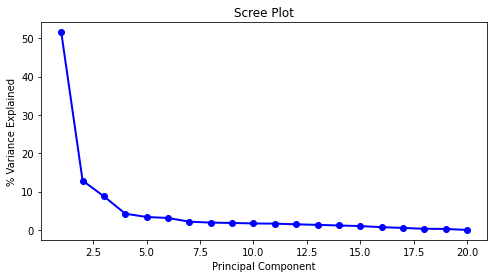

91.5171984641986


In [22]:
#Scree plot
x = eigen_values
w = []
z = []
cnt = 1
for i in x:
    w.append(100*(i/sum(x)))
    z.append(cnt)
    cnt+=1
    
w = sorted(w, key=float, reverse=True)
plt.rcParams["figure.figsize"] = (8, 4)
plt.plot(z, w,'o-', linewidth=2, color='blue')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('% Variance Explained')
plt.show()

x=0
for i in range(0,10):
    x += w[i]
    
print(x)

In [23]:
#calculate factor loadings
factor_loading = pd.DataFrame(eigen_vectors)
factor_loading.columns = ['FL1', 'FL2', 'FL3', 'FL4', 'FL5', 'FL6','FL7', 'FL8', 'FL9', 'FL10', 'FL11', 'FL12',
                   'FL13', 'FL14', 'FL15', 'FL16','FL17', 'FL18', 'FL19', 'FL20']
factor_loading.index = daily_returns.columns
factor_loading

,FL1,FL2,FL3,FL4,FL5,FL6,FL7,FL8,FL9,FL10,FL11,FL12,FL13,FL14,FL15,FL16,FL17,FL18,FL19,FL20
AAPL,0.237766,0.049222,0.065033,-0.010296,0.141618,0.025590,0.007505,-0.013613,-0.011150,0.080895,0.002005,-0.098684,0.146664,0.325053,0.372455,-0.273492,-0.045662,0.588676,0.431772,-0.153639
ADBE,0.258631,0.034278,0.198908,-0.119488,0.137468,-0.043435,-0.002071,0.051898,-0.024121,0.298540,-0.025887,0.258882,-0.069597,0.454308,-0.367632,0.321800,-0.425529,-0.097872,0.141767,0.191086
AMZN,0.211124,-0.005582,0.274514,-0.166997,0.016470,0.100285,0.009049,-0.083348,-0.027206,0.176840,0.011410,-0.048710,0.071932,-0.587645,-0.490964,-0.153345,-0.136265,0.273808,0.029289,-0.301362
BAC,0.223976,0.204483,-0.420302,0.036197,-0.403590,0.138210,0.002428,0.188610,0.606234,0.056429,-0.020845,-0.237414,-0.097631,0.000948,-0.076979,0.038499,-0.232446,0.108360,-0.044169,0.017951
DIS,0.169802,0.127634,-0.261920,-0.088569,-0.080916,0.196532,0.002489,-0.015061,0.034242,-0.020915,0.014629,0.543506,-0.016168,0.211343,-0.277982,-0.080621,0.576788,0.022644,0.042292,-0.268545
FB,0.233876,0.059367,0.189892,-0.136589,0.171258,0.463994,-0.002169,-0.025939,0.007028,-0.052177,0.005940,-0.429662,-0.073412,0.062363,-0.141433,-0.059404,0.389772,-0.058751,0.026874,0.515209
GOOG,0.219447,0.081742,0.085955,-0.120334,0.143396,0.190049,-0.704868,0.037607,-0.012343,0.080232,-0.028078,-0.084497,0.034008,0.050501,0.258693,0.185505,-0.017582,-0.124620,-0.335882,-0.346616
GOOGL,0.219354,0.081699,0.085458,-0.114509,0.148860,0.183741,0.709101,0.036957,-0.010164,0.066394,-0.018944,-0.082235,0.032940,0.052533,0.258629,0.194699,-0.016978,-0.133962,-0.337045,-0.335524
HD,0.184455,0.086398,-0.096169,0.044508,0.030576,-0.163042,-0.005255,0.051853,0.041895,0.087426,0.143018,0.047073,0.433797,-0.335996,0.146080,0.624154,0.246404,0.047682,0.292145,0.157042
JNJ,0.107747,0.110997,-0.082067,-0.067400,0.163071,-0.333243,-0.004930,0.013067,0.005504,0.157249,0.783262,-0.020835,-0.210243,0.017027,-0.005844,-0.125044,0.074822,0.145261,-0.297294,0.114097


In [24]:
#Determine highest contributer to each factor
m = []
for i in factor_loading.columns:
    a = min((factor_loading[i]))
    b = max(factor_loading[i])
    
    if abs(a) > abs(b):
        y =factor_loading[i].to_list()
        y = y.index(a)
        m.append(daily_returns.columns[y])
    else:
        y =factor_loading[i].to_list()
        y = y.index(b)
        m.append(daily_returns.columns[y])

print(m)

['TSLA', 'TSLA', 'NFLX', 'NVDA', 'NFLX', 'FB', 'GOOGL', 'V', 'JPM', 'MSFT', 'JNJ', 'DIS', 'PFE', 'AMZN', 'AMZN', 'HD', 'DIS', 'AAPL', 'PFE', 'FB']


In [25]:
#determine the factors to be used 
factors = np.matmul(Y , eigen_vectors)
factors = pd.DataFrame(factors)
factors = factors.iloc[:,0:10]
factors.columns = ['F1', 'F2', 'F3', 'F4', 'F5', 'F6','F7', 'F8', 'F9', 'F10']
factors

,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10
0,0.040757,-0.028796,-0.010873,0.008650,-0.012873,0.001874,-0.000862,0.002547,0.010269,0.007744
1,0.009403,0.004075,0.022205,-0.042935,0.014027,0.001067,-0.001444,-0.006523,0.000026,0.011660
2,0.033385,0.002145,0.011450,-0.000930,0.016815,0.024936,-0.000040,-0.006860,0.001154,0.005007
3,0.012846,-0.008287,0.016989,0.033548,-0.001161,0.004973,0.001173,0.001662,-0.005786,0.003661
4,-0.011919,0.009822,-0.014237,0.000419,-0.006786,0.005393,0.000639,0.005874,0.008806,-0.000019
...,...,...,...,...,...,...,...,...,...,...
1000,-0.007571,0.009271,-0.053051,-0.007674,-0.004990,0.013586,-0.000068,-0.003902,-0.000844,0.003978
1001,0.017663,-0.013153,-0.009987,-0.003255,0.016322,-0.006078,-0.000317,0.001244,0.002066,-0.000236
1002,0.049958,0.018693,0.005867,-0.029969,0.015626,0.032134,0.001732,-0.002553,-0.001669,0.004645
1003,-0.002434,-0.004994,0.013984,-0.006807,-0.012887,-0.014448,0.000472,-0.003926,-0.000459,0.004451


In [26]:
#Minimise for volatility and calculate the optimal weighting of each factor

daily_factor_returns = factors.mean() #should be close to zero
annual_factor_returns = daily_factor_returns*252
cov = factors.cov()*252 #annualised covariance matrix
# cov = factors.cov() #daily


optimiser  = pypfopt.EfficientFrontier(annual_factor_returns,cov, solver='CVXOPT', weight_bounds=(0,1))
optimal_factor_weights = optimiser.efficient_risk(0.2)
optimal_factor_weights
perf = optimiser.portfolio_performance(verbose=True)


Expected annual return: -0.0%
Annual volatility: 9.1%
Sharpe Ratio: -0.22


In [27]:
#Determine the optimal portfolio

eigen_vectors = pd.DataFrame(eigen_vectors)
factor_eigen_vectors = eigen_vectors.iloc[:,0:10]
factor_eigen_vectors = abs(factor_eigen_vectors)
factor_eigen_vectors = factor_eigen_vectors/factor_eigen_vectors.sum(axis=0) #weighting of each stock in each factor

mean_annual_returns = mean_daily_returns*252 #annual returns of each stock

factor_weights = []
for i in factors.columns:
    factor_weights.append(optimal_factor_weights[i]) #converts dictionary to list
factor_weights

''' 
This next line mulitplies the weightings of each stock in a given factor 
by the optimised weighting of the given factor. For example, if the optimiser shown 
above allocates a weighting of 0.05 to factor 1, then the proportion of all the stocks in 
factor 1 is multiplied by 0.05
'''
factor_eigen_vectors.iloc[:, 0:] *= factor_weights


'''
These two lines calculate the sum of all stocks accross all factors to get a weighted average
of each factors optimal portfolio weighting, this is then used as the final portfolio weighting.
To get the annual return of the portfolio, the weightings are multiplied by the mean annual return of
their respective stocks
'''
portfolio_weights = factor_eigen_vectors.sum(axis=1)
portfolio_annual_return = portfolio_weights*mean_annual_returns

r = round(sum(100*portfolio_annual_return),2)
m = round(100*np.mean(mean_annual_returns),2)

print(f"Annual Portfolio Return: {r}%")
print(f"Annual Market Return: {m}%")
print(f"Portfolio Volatility: {100*np.round(perf[1],6)}%")

Annual Portfolio Return: 30.8%
Annual Market Return: 31.67%
Portfolio Volatility: 9.0614%


In [28]:
#final portfolio allocation
portfolio_weights = pd.DataFrame(portfolio_weights)
portfolio_weights.index = daily_returns.columns
portfolio_weights.columns = ['Stock_Weighting']
portfolio_weights

,Stock_Weighting
AAPL,0.016862
ADBE,0.038246
AMZN,0.035160
BAC,0.084701
DIS,0.027916
FB,0.038139
GOOG,0.086029
GOOGL,0.085231
HD,0.024478
JNJ,0.033533


<AxesSubplot:ylabel='Stock_Weighting'>

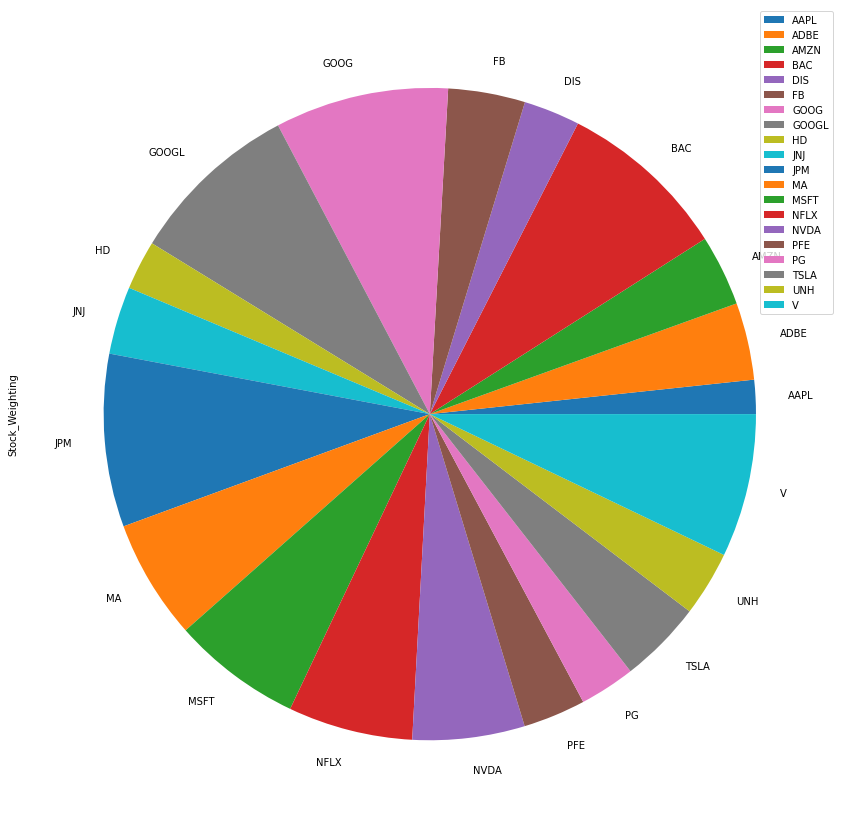

In [29]:
#portfolio visualisation
portfolio_weights.plot.pie(y='Stock_Weighting', figsize=(15, 15))